In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [ ]:
# install kaggle package
!pip install -q kaggle

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devisdestiannugraha","key":"bee36c4a86c43a4117f92345da40f1e2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 8.77MB/s]


In [ ]:
# unzip
!mkdir daily-climate-time-series-data
!unzip daily-climate-time-series-data.zip -d daily-climate-time-series-data
!ls daily-climate-time-series-data

Archive:  daily-climate-time-series-data.zip
  inflating: daily-climate-time-series-data/DailyDelhiClimateTest.csv  
  inflating: daily-climate-time-series-data/DailyDelhiClimateTrain.csv  
DailyDelhiClimateTest.csv  DailyDelhiClimateTrain.csv


In [ ]:
# load dataset
import pandas as pd
data_train = pd.read_csv('daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
data_train.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In [ ]:
# total data
data_train.shape

(1462, 5)

In [ ]:
# data info
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
# null check
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'Temperature average')

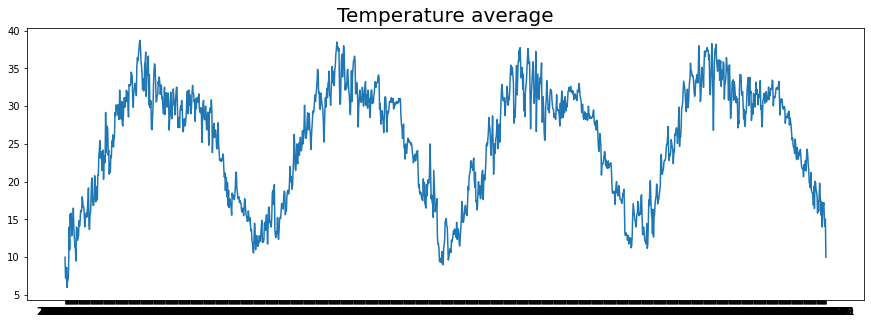

In [ ]:
dates = data_train['date'].values
temp  = data_train['meantemp'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20)

In [ ]:
# get data values
date = data_train['date'].values
temp = data_train['meantemp'].values

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

1169 293


In [ ]:
# model
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
max = data_train['meantemp'].max()
print('Max value : ' )
print(max)

Max value : 
38.714285714285715


In [ ]:
min = data_train['meantemp'].min()
print('Min value : ' )
print(min)

Min value : 
6.0


In [ ]:
x = (max - min) * (10 / 100)
print(x)

3.271428571428572


In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [ ]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=100, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/100
12/12 [==============================] - 2s 154ms/step - loss: 3.0156 - mae: 3.4734 - val_loss: 3.1476 - val_mae: 3.5991
Epoch 2/100
12/12 [==============================] - 2s 155ms/step - loss: 3.0120 - mae: 3.4697 - val_loss: 3.1445 - val_mae: 3.5959
Epoch 3/100
12/12 [==============================] - 2s 149ms/step - loss: 3.0084 - mae: 3.4661 - val_loss: 3.1348 - val_mae: 3.5860
Epoch 4/100
12/12 [==============================] - 2s 150ms/step - loss: 3.0049 - mae: 3.4626 - val_loss: 3.1285 - val_mae: 3.5796
Epoch 5/100
12/12 [==============================] - 2s 150ms/step - loss: 3.0013 - mae: 3.4589 - val_loss: 3.1299 - val_mae: 3.5809
Epoch 6/100
12/12 [==============================] - 2s 150ms/step - loss: 2.9975 - mae: 3.4550 - val_loss: 3.1213 - val_mae: 3.5723
Epoch 7/100
12/12 [==============================] - 2s 152ms/step - loss: 2.9938 - mae: 3.4514 - val_loss: 3.1130 - val_mae: 3.5639
Epoch 8/100
12/12 [==============================] - 2s 151ms/step - 

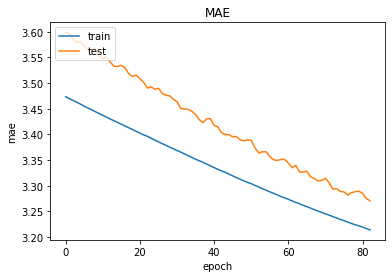

In [ ]:
# plot of mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

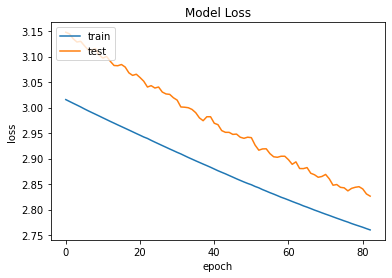

In [ ]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()